# PODS Capstone

### Importing packages

In [2304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from scipy import stats
print("imported")

imported


Initializing random seed

In [2305]:
rand = np.random.RandomState(16093457)
alpha = 0.005

Importing data

In [2306]:
rmp_num_df = pd.read_csv("rmpCapstoneNum.csv", delimiter=",")
rmp_num_np = rmp_num_df.to_numpy()
rmp_qual_df = pd.read_csv("rmpCapstoneQual.csv", delimiter=",")
rmp_qual_np = rmp_qual_df.to_numpy()

print(rmp_num_np.shape, rmp_qual_np.shape)

(89892, 8) (89892, 3)


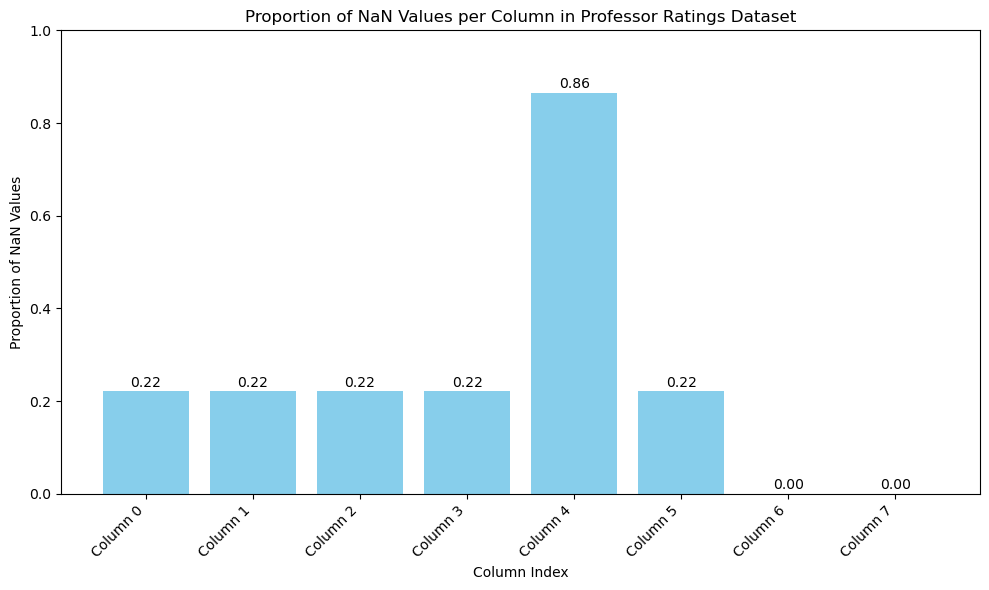

NaN proportions per column: [0.22125439 0.22125439 0.22125439 0.22125439 0.86472656 0.22125439
 0.         0.        ]


In [2307]:
# Calculate the proportion of NaN values in each column
num_rows = rmp_num_np.shape[0]
nan_proportions = np.isnan(rmp_num_np).sum(axis=0) / num_rows

# Create column labels for the plot
num_cols = rmp_num_np.shape[1]
col_labels = [f"Column {i}" for i in range(num_cols)]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(col_labels, nan_proportions, color='skyblue')

# Add labels and title
plt.xlabel("Column Index")
plt.ylabel("Proportion of NaN Values")
plt.title("Proportion of NaN Values per Column in Professor Ratings Dataset")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.ylim(0, 1) # Set y-axis limit from 0 to 1

# Add text labels on top of bars
for i, prop in enumerate(nan_proportions):
    plt.text(i, prop + 0.01, f"{prop:.2f}", ha='center') # Adjust offset as needed

# Show plot
plt.tight_layout()
plt.show()

print("NaN proportions per column:", nan_proportions)


Preprocessing

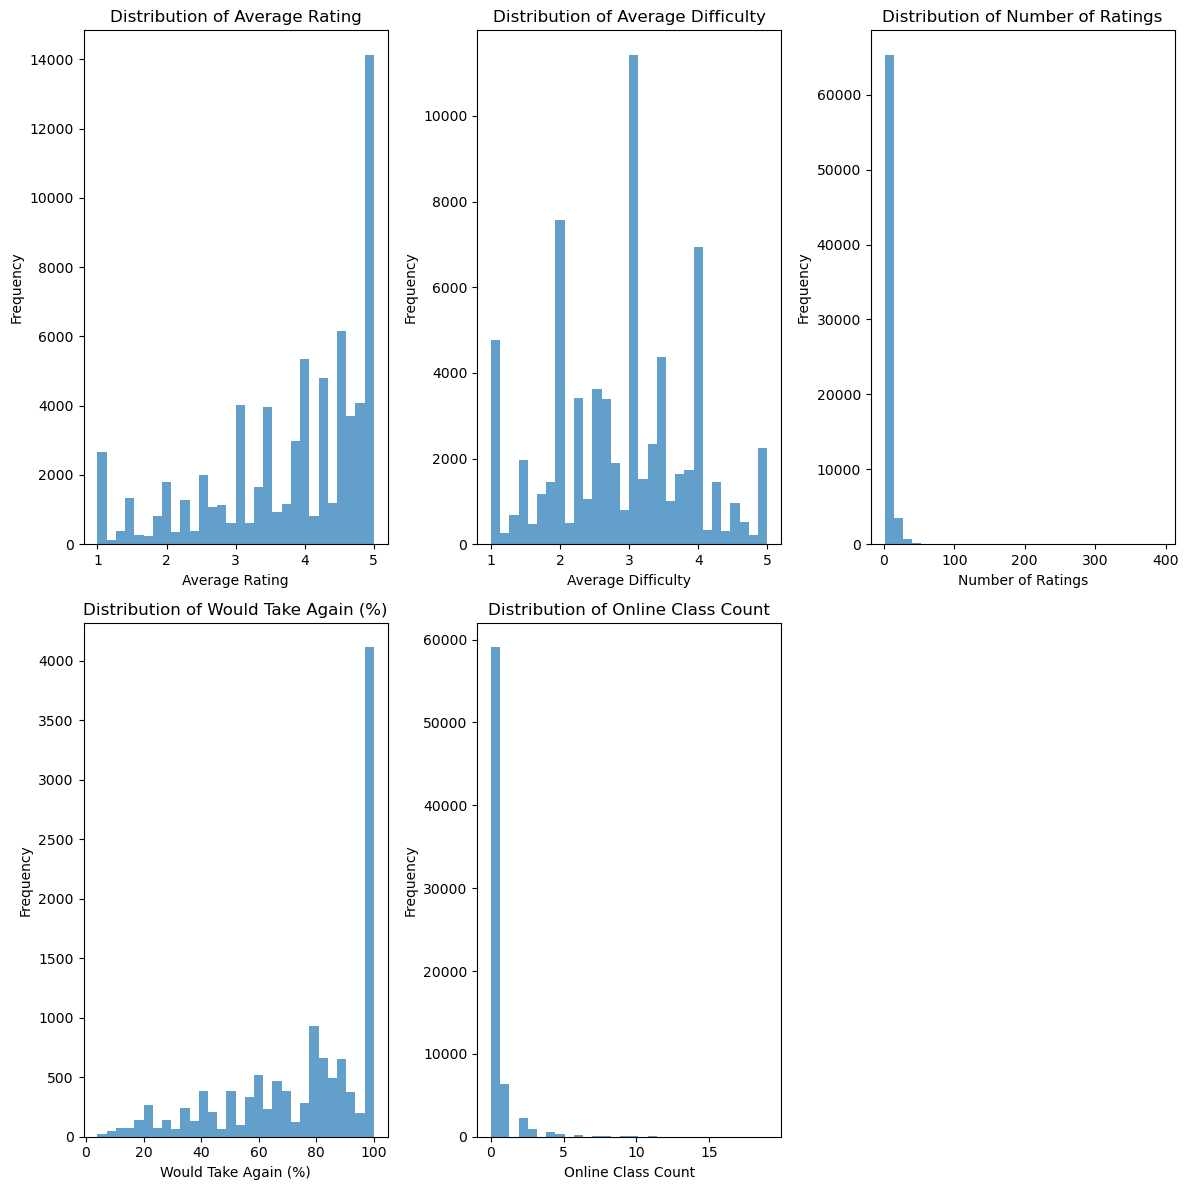

In [2308]:

avg_rating = rmp_num_np[:, 0]
avg_difficulty = rmp_num_np[:, 1]
num_ratings = rmp_num_np[:, 2]
pepper = rmp_num_np[:, 3]
would_take_again = rmp_num_np[:, 4]
online_class = rmp_num_np[:, 5]
male = rmp_num_np[:, 6]
female = rmp_num_np[:, 7]

# List of columns and their names
columns = [avg_rating, avg_difficulty, num_ratings, would_take_again, online_class]
column_names = ['Average Rating', 'Average Difficulty', 'Number of Ratings', 'Would Take Again (%)', 'Online Class Count']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.ravel() # Flatten the 2D array of axes for easy iteration

# Plot distribution for each column
for i, (col, name) in enumerate(zip(columns, column_names)):
    # Filter out NaNs for plotting, as hist might behave unexpectedly otherwise or show warnings
    col_clean = col[~np.isnan(col)]
    axes[i].hist(col_clean, bins=30, alpha=0.7)
    axes[i].set_title(f'Distribution of {name}')
    axes[i].set_xlabel(name)
    axes[i].set_ylabel('Frequency')

    # Check if this is the last column being plotted
    if i == len(columns) - 1:
        # Hide any remaining unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [2309]:
avg_rating_clean = np.nan_to_num(avg_rating, nan=np.nanmedian(avg_rating))
avg_difficulty_clean =  np.nan_to_num(avg_difficulty, nan=np.nanmean(avg_difficulty))
num_ratings_clean = np.nan_to_num(num_ratings, nan=np.nanmedian(num_ratings))

would_take_again_clean = np.nan_to_num(would_take_again, nan=np.nanmedian(would_take_again))
online_class_clean = np.nan_to_num(online_class, nan=np.nanmedian(online_class))

Handling binary data: Pepper, male, female

In [2310]:
male_clean = np.where((male == 1) & (female == 0), 1, 0)
female_clean = np.where((female == 1) & (male == 0), 1, 0)

In [2311]:
pepper_clean = np.nan_to_num(pepper, 0)

Determining a threshold for num_ratings: which averages to accept


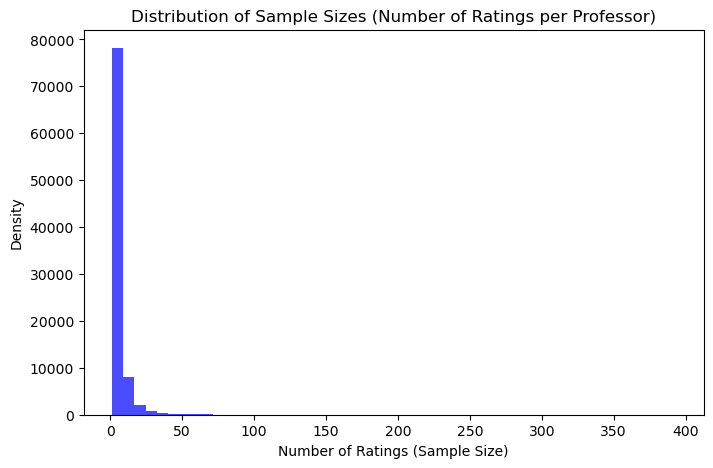

Descriptive statistics for 'sample_sizes':
Mean: 4.85
Median: 3.00
Standard Deviation: 7.25
Min: 1.00
Max: 393.00


In [2312]:
sample_sizes = num_ratings_clean  # Filter out professors with zero ratings
# Plot the distribution of sample sizes (number of ratings)
plt.figure(figsize=(8, 5))
plt.hist(sample_sizes, bins=50, alpha=0.7, color='blue') # Using more bins might be helpful due to potential skewness
plt.xlabel("Number of Ratings (Sample Size)")
plt.ylabel("Density")
plt.title("Distribution of Sample Sizes (Number of Ratings per Professor)")
plt.show()

# Print some descriptive statistics for sample sizes
print("Descriptive statistics for 'sample_sizes':")
print(f"Mean: {np.mean(sample_sizes):.2f}")
print(f"Median: {np.median(sample_sizes):.2f}")
print(f"Standard Deviation: {np.std(sample_sizes):.2f}")
print(f"Min: {np.min(sample_sizes):.2f}")
print(f"Max: {np.max(sample_sizes):.2f}")

In [2313]:
data_clean = np.column_stack((avg_rating_clean, avg_difficulty_clean, num_ratings_clean,
                             pepper_clean, would_take_again_clean,
                             online_class_clean, male_clean, female_clean))

print("Cleaned data shape:", data_clean.shape)

print(would_take_again_clean)

Cleaned data shape: (89892, 8)
[ 83.  83.  83. ... 100.  83.  83.]


In [2314]:
impacts = np.array([]).reshape(0, 2)  # To store (sample size, impact) pairs
candidates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
impact_size = np.array([]).reshape(0, 2)
sample_size_thresh = []
for cand in candidates:
    res = []
    for i in range(len(avg_rating_clean)):
        worst_case = max(avg_rating_clean[i] - 1, 5- avg_rating_clean[i])
        adjusted_rating = ((avg_rating_clean[i] * num_ratings_clean[i]) + worst_case) / (num_ratings_clean[i] + 1)
        impact = abs(adjusted_rating - avg_rating_clean[i])
        if impact > cand:
            impacts = np.vstack((impacts, (num_ratings_clean[i], impact)))
            res.append(num_ratings_clean[i])
            

    print(cand, max(res), len(res))
    sample_size_thresh.append(max(res))
    impact_size = np.vstack((impact_size, (cand, len(res) / len(avg_rating_clean))))

0.1 27.0 75809
0.2 12.0 60579
0.3 9.0 28774
0.4 6.0 18617
0.5 4.0 3731
0.6 4.0 3665
0.7 3.0 3152


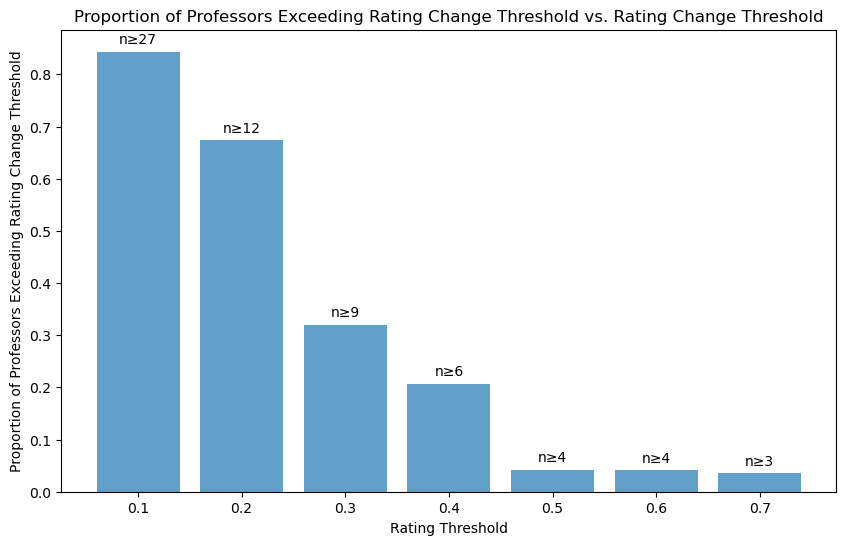

In [2315]:
# Plot the impact size vs. sample size
plt.figure(figsize=(10, 6))
plt.bar(impact_size[:, 0], impact_size[:, 1], width=0.08, alpha=0.7) # Use a bar chart to show count per threshold
# Add text labels (sample size threshold) on top of bars
for i, impact_thresh in enumerate(impact_size[:, 0]):
    proportion = impact_size[i, 1]
    threshold_label = int(sample_size_thresh[i]) # Convert to int for cleaner display
    plt.text(impact_thresh, proportion + 0.01, f"n≥{threshold_label}", ha='center', va='bottom') # Adjust offset as needed
plt.xlabel("Rating Threshold")
plt.ylabel("Proportion of Professors Exceeding Rating Change Threshold")
plt.title("Proportion of Professors Exceeding Rating Change Threshold vs. Rating Change Threshold")   
plt.show()

In [2316]:
impacts = impact_size[:, 0] 
# Create a DataFrame to display the results
impact_threshold_df = pd.DataFrame({
    'Impact Threshold': impacts,
    'Sample Size Threshold': sample_size_thresh
})

# Print the table
print(impact_threshold_df)

print(len(num_ratings_clean[num_ratings_clean > 4]) / len(num_ratings_clean))

data_clean = data_clean[num_ratings_clean >= 4]


   Impact Threshold  Sample Size Threshold
0               0.1                   27.0
1               0.2                   12.0
2               0.3                    9.0
3               0.4                    6.0
4               0.5                    4.0
5               0.6                    4.0
6               0.7                    3.0
0.28220531304231744


In [2317]:
print(len(data_clean))
print(len(rmp_num_np))

31951
89892


### Looking at gender bias in rmp ratings


In [2318]:
prof_rating = data_clean[:, 0]
male = data_clean[:, 6]
female = data_clean[:, 7]

In [2319]:
male_ratings = prof_rating[male == 1]
female_ratings = prof_rating[female == 1]

print(male_ratings.shape)
print(female_ratings.shape)

(12463,)
(10818,)


Exploratory data analysis

In [2320]:
print("Mean Male professor Rating:", np.mean(male_ratings))
print("Mean Female professor Rating:", np.mean(female_ratings))

print("Median Male professor Rating:", np.median(male_ratings))
print("Median Female professor Rating:", np.median(female_ratings))

Mean Male professor Rating: 3.9047019176763222
Mean Female professor Rating: 3.8427343316694396
Median Male professor Rating: 4.2
Median Female professor Rating: 4.1


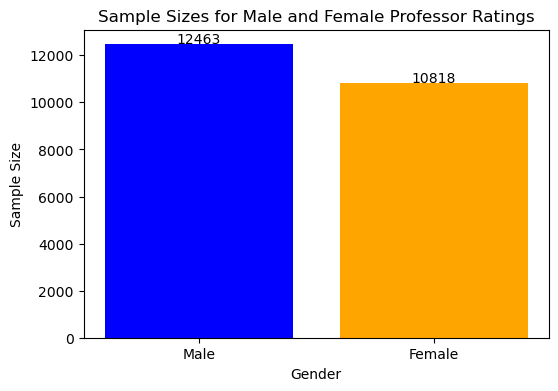

In [2321]:
male_sample_size = len(male_ratings)
female_sample_size = len(female_ratings)
# Data for plotting
labels = ['Male', 'Female']
sizes = [male_sample_size, female_sample_size]

# Create bar plot
plt.figure(figsize=(6, 4)) # Optional: Adjust figure size
plt.bar(labels, sizes, color=['blue', 'orange'])

# Add labels and title
plt.xlabel("Gender")
plt.ylabel("Sample Size")
plt.title("Sample Sizes for Male and Female Professor Ratings")

# Add text labels on top of bars
for i, size in enumerate(sizes):
    plt.text(i, size + 30, str(size), ha='center') # Adjust offset as needed

# Show plot
plt.show()

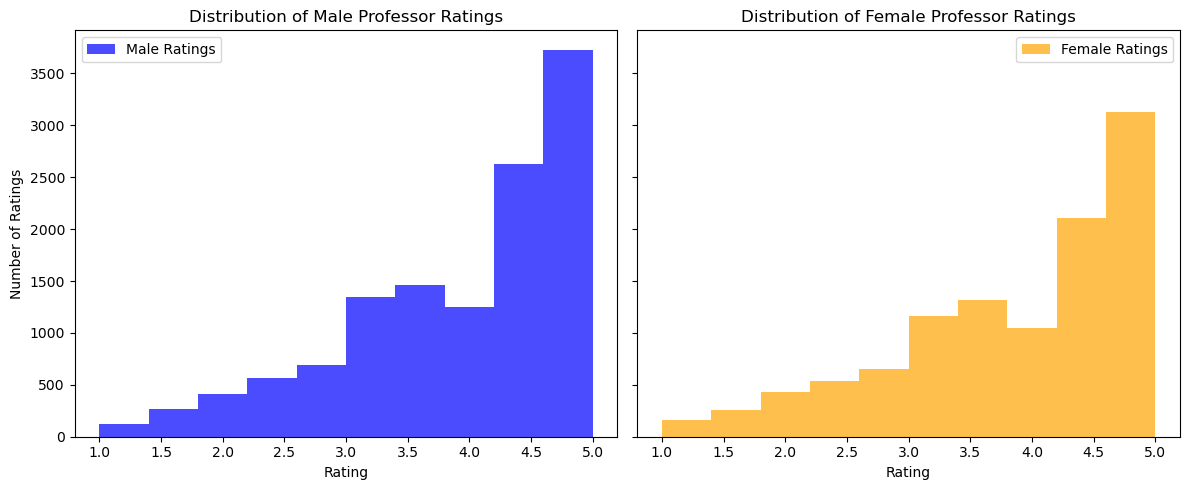

In [2322]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True) # sharey makes y-axis scale same

# Plot male ratings on the first subplot
axes[0].hist(male_ratings, alpha=0.7, label='Male Ratings', density=False, color='blue')
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Number of Ratings")
axes[0].set_title("Distribution of Male Professor Ratings")
axes[0].legend()

# Plot female ratings on the second subplot
axes[1].hist(female_ratings, alpha=0.7, label='Female Ratings', density=False, color='orange')
axes[1].set_xlabel("Rating")
# axes[1].set_ylabel("Density") # Y-label is shared
axes[1].set_title("Distribution of Female Professor Ratings")
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

Trying with ind t-test

In [2323]:
t_stat, p_val = stats.ttest_ind(male_ratings, female_ratings)
print("t-statistic:", t_stat)
print("p-value:", p_val)
if p_val < alpha:
    print("Reject null hypothesis: there is a significant difference in ratings")

t-statistic: 4.946976114668299
p-value: 7.590049627659127e-07
Reject null hypothesis: there is a significant difference in ratings


Distributions aren't normal: Trying mann whitney u

In [2324]:
u_stat, p_val_u = stats.mannwhitneyu(male_ratings, female_ratings)
print("Mann-Whitney U statistic:", u_stat)
print("Mann-Whitney p-value:", p_val_u)
if p_val_u < alpha:
    print("Reject null hypothesis: there is a significant difference in ratings (Mann-Whitney U test)")


Mann-Whitney U statistic: 69429525.5
Mann-Whitney p-value: 7.868525744356902e-05
Reject null hypothesis: there is a significant difference in ratings (Mann-Whitney U test)


In [2325]:
mean1 = np.mean(male_ratings)
mean2 = np.mean(female_ratings)
effect_size = (mean1 - mean2) / np.sqrt((np.var(male_ratings) + np.var(female_ratings)) / 2)
print("Effect size (Cohen's d):", effect_size)

Effect size (Cohen's d): 0.06490284914454413


### Effect of experience on teaching quality

In [2326]:
quality = prof_rating
experience = data_clean[:, 2]

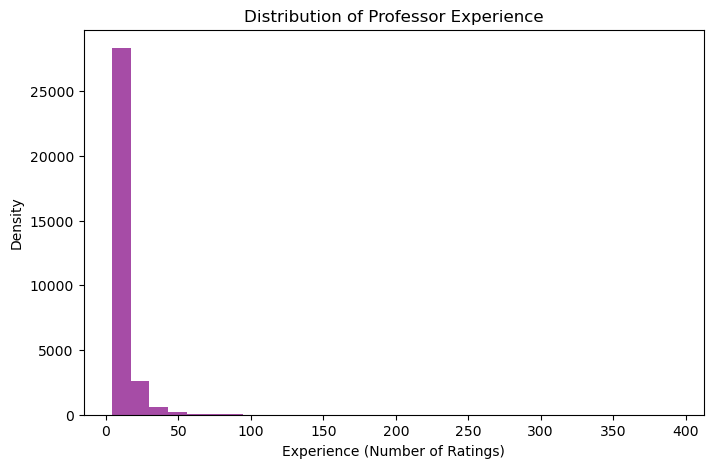

In [2327]:
# Plot the distribution of experience
plt.figure(figsize=(8, 5))
plt.hist(experience, bins=30, alpha=0.7, color='purple')
plt.xlabel("Experience (Number of Ratings)")
plt.ylabel("Density")
plt.title("Distribution of Professor Experience")
plt.show()

mean experience: 9.677380989640387
median experience: 7.0
mean quality: 3.8326406059278275
median quality: 4.1


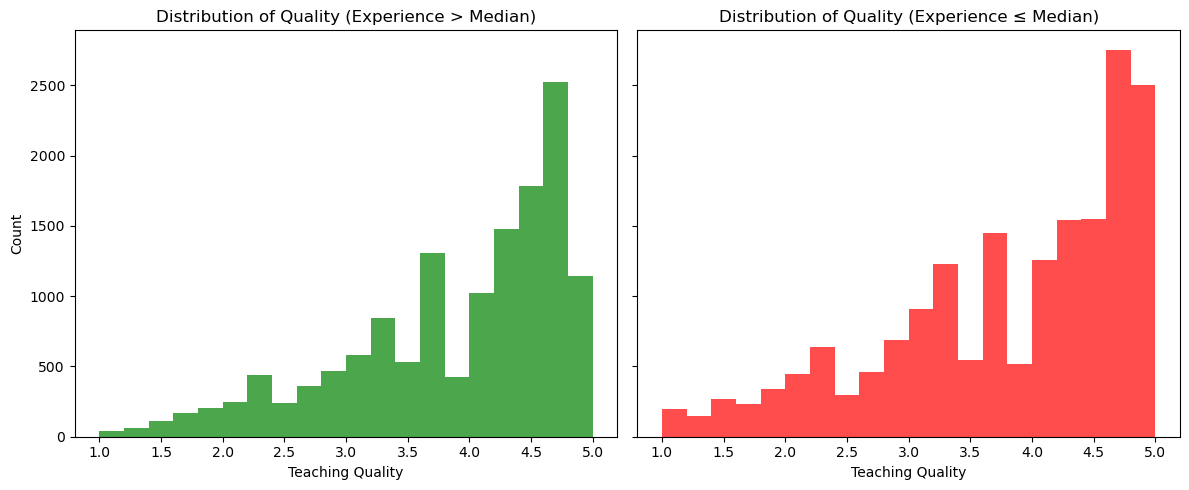

In [2328]:
mean_experience = np.mean(experience)
print("mean experience:", mean_experience)
median_experience = np.median(experience)
print("median experience:", median_experience)

mean_quality = np.mean(quality)
print("mean quality:", mean_quality)
median_quality = np.median(quality)
print("median quality:", median_quality)

high_experience_qual = quality[experience > median_experience]
low_experience_qual = quality[experience <= median_experience]

# Plot distributions of quality for high vs. low experience groups
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(high_experience_qual, bins=20, alpha=0.7, color='green')
axes[0].set_title("Distribution of Quality (Experience > Median)")
axes[0].set_xlabel("Teaching Quality")
axes[0].set_ylabel("Count")

axes[1].hist(low_experience_qual, bins=20, alpha=0.7, color='red')
axes[1].set_title("Distribution of Quality (Experience ≤ Median)")
axes[1].set_xlabel("Teaching Quality")

plt.tight_layout()
plt.show()

Trying mann-whitney

In [2329]:
#mann-whitney
u_stat, p_val = stats.mannwhitneyu(high_experience_qual, low_experience_qual)
print(f"U-statistic: {u_stat}")
print(f"p-value: {p_val}")
if p_val < alpha:
    print("Reject null hypothesis: there is a significant difference in ratings")

U-statistic: 127677193.0
p-value: 0.012981636529338429


### Looking at avg rating vs avg difficuly

In [2330]:
avg_difficulty = data_clean[:, 1]

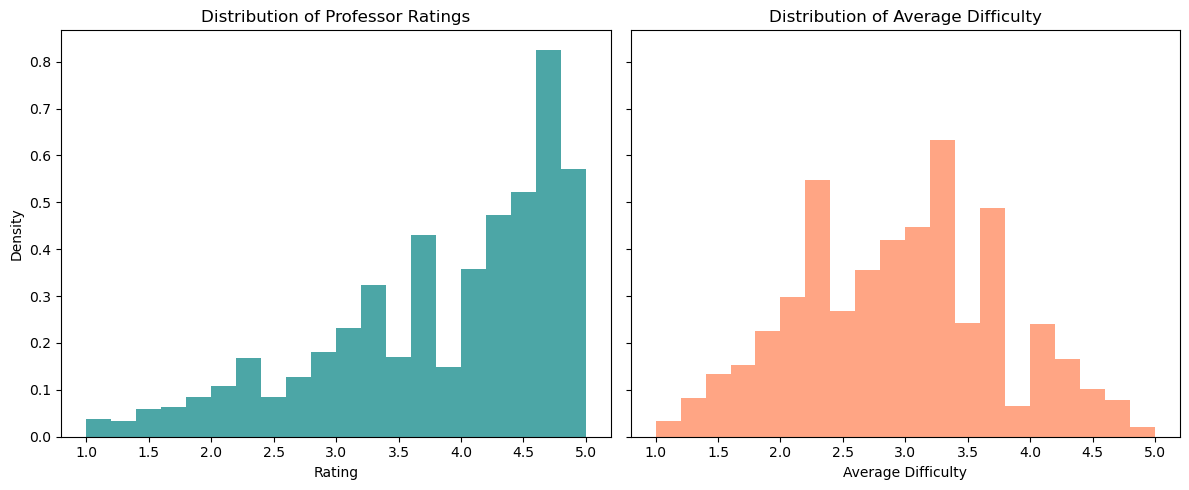

In [2331]:
# Plot distributions of professor ratings and average difficulty side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Distribution of professor ratings
axes[0].hist(prof_rating, bins=20, density=True, alpha=0.7, color='teal')
axes[0].set_title("Distribution of Professor Ratings")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Density")

# Distribution of average difficulty
axes[1].hist(avg_difficulty, bins=20, density=True, alpha=0.7, color='coral')
axes[1].set_title("Distribution of Average Difficulty")
axes[1].set_xlabel("Average Difficulty")

plt.tight_layout()
plt.show()

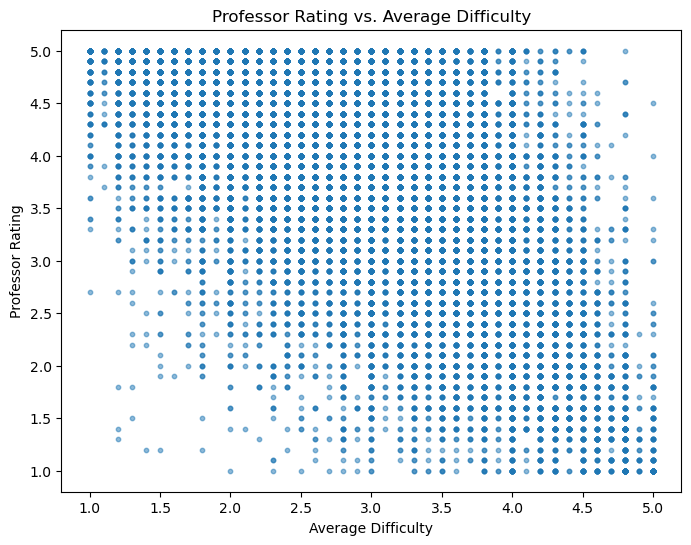

In [2332]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(avg_difficulty, prof_rating, alpha=0.5, s=10) # s controls point size, alpha controls transparency

# Add labels and title
plt.xlabel("Average Difficulty")
plt.ylabel("Professor Rating")
plt.title("Professor Rating vs. Average Difficulty")

# Show plot
plt.show()

Pearson corr

In [2333]:
corr = np.corrcoef(prof_rating, avg_difficulty)[0, 1]
print("Correlation coefficient:", corr)

Correlation coefficient: -0.6074669235530487


spearman corr

Spearman correlation coefficient: -0.5900916640793104
Spearman p-value: 0.0


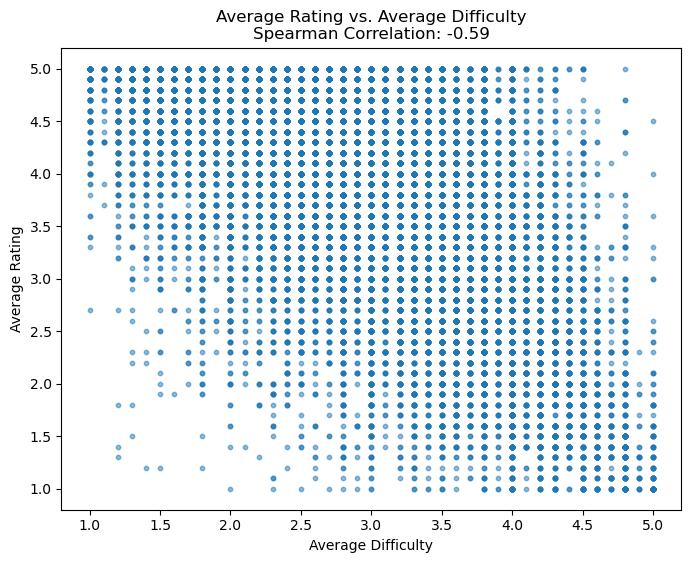

In [2334]:
from scipy.stats import spearmanr

# Calculate Spearman correlation
corr_spearman, p_val = spearmanr(prof_rating, avg_difficulty)
print("Spearman correlation coefficient:", corr_spearman)
print(f"Spearman p-value: {p_val}")

# Create scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(avg_difficulty, prof_rating, alpha=0.5, s=10) # s controls point size, alpha controls transparency

# Add labels and title, including the Spearman correlation
plt.xlabel("Average Difficulty")
plt.ylabel("Average Rating")
plt.title(f"Average Rating vs. Average Difficulty\nSpearman Correlation: {corr_spearman:.2f}")

# Show plot
plt.show()

### Teaching a lot of classes online : Higher or lower ratings?

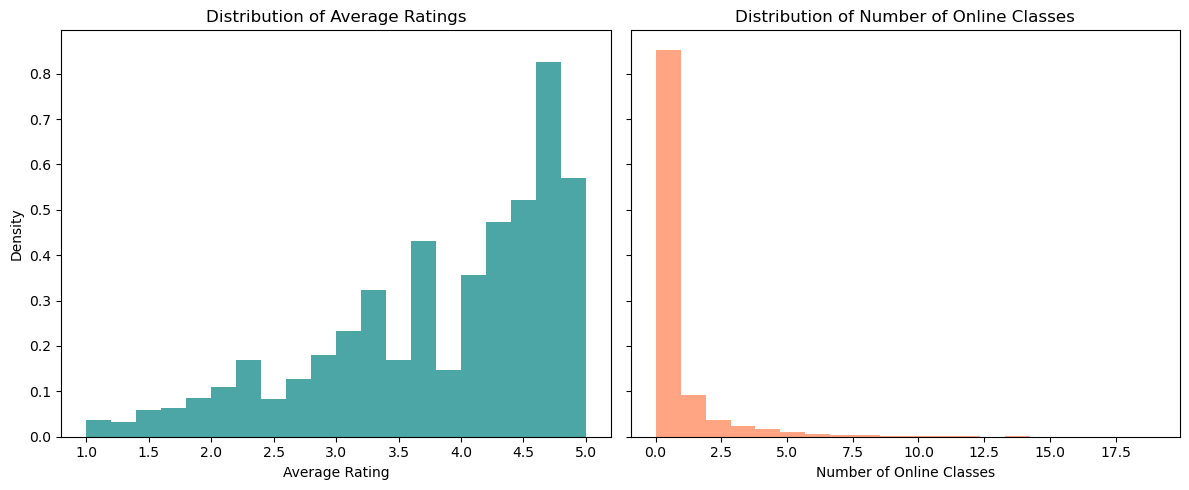

In [2335]:
avg_rating = data_clean[:, 0]
num_online = data_clean[:, 5]

# Plot distributions of average rating and number of online classes side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Distribution of average rating
axes[0].hist(avg_rating, bins=20, density=True, alpha=0.7, color='teal')
axes[0].set_title("Distribution of Average Ratings")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Density")
# Distribution of number of online classes
axes[1].hist(num_online, bins=20, density=True, alpha=0.7, color='coral')
axes[1].set_title("Distribution of Number of Online Classes")
axes[1].set_xlabel("Number of Online Classes")
plt.tight_layout()
plt.show()

What counts as "a lot of classes" online?

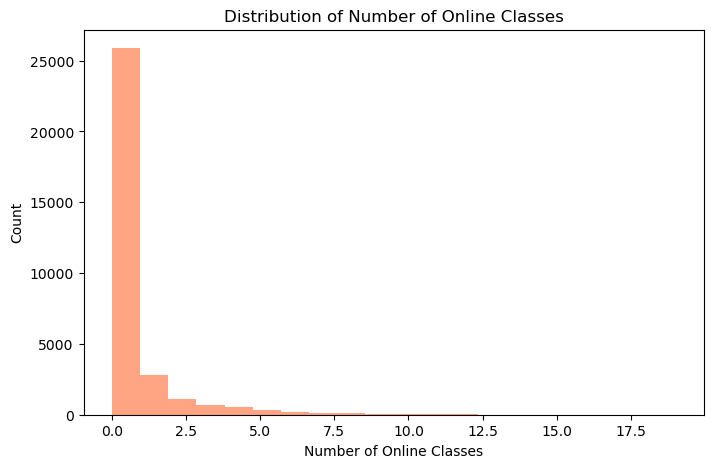

In [2336]:
# Plot distribution of number of online classes
plt.figure(figsize=(8, 5))
plt.hist(num_online, bins=20, alpha=0.7, color='coral')
plt.xlabel("Number of Online Classes")
plt.ylabel("Count")
plt.title("Distribution of Number of Online Classes")
plt.show()

Median number of online classes: 0.0
Mean number of online classes: 0.4891865669306125
Mode number of online classes: 0.0
Mean average rating: 3.8326406059278275
Median average rating: 4.1
Mode average rating: 4.8


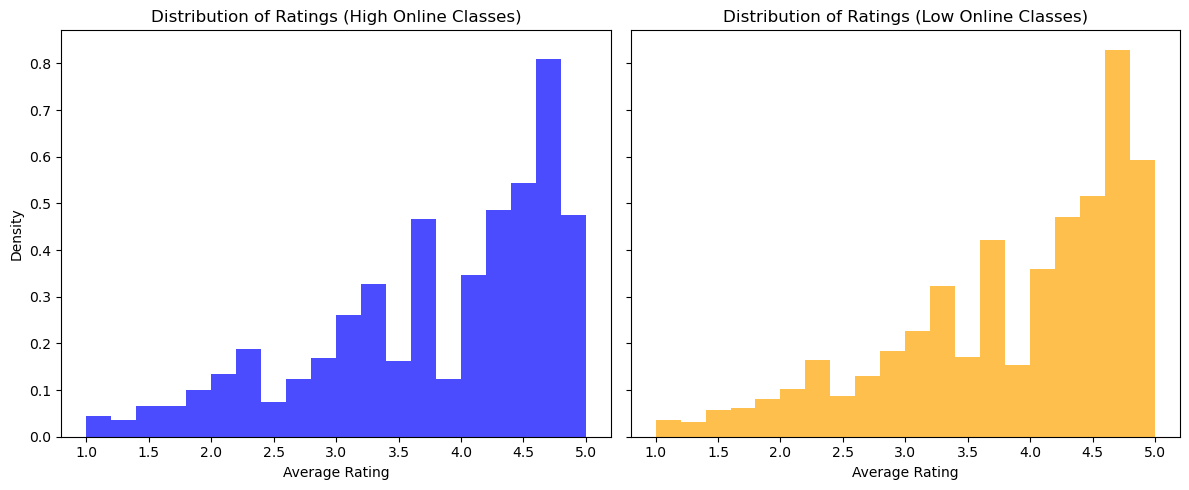

In [2337]:
# Calculate median, mean, and mode for number of online classes
median_online = np.median(num_online)
mean_online = np.mean(num_online)
mode_online = stats.mode(num_online).mode

print(f"Median number of online classes: {median_online}")
print(f"Mean number of online classes: {mean_online}")
print(f"Mode number of online classes: {mode_online}")

mean_avg_rating = np.mean(avg_rating)   
median_avg_rating = np.median(avg_rating)
mode_avg_rating = stats.mode(avg_rating).mode
print(f"Mean average rating: {mean_avg_rating}")
print(f"Median average rating: {median_avg_rating}")
print(f"Mode average rating: {mode_avg_rating}")

onl_thresh = 1
high_online = avg_rating[num_online >= onl_thresh]
low_online  = avg_rating[num_online < onl_thresh]
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(high_online, bins=20, density=True, alpha=0.7, color='blue')
axes[0].set_title("Distribution of Ratings (High Online Classes)")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Density")

axes[1].hist(low_online, bins=20, density=True, alpha=0.7, color='orange')
axes[1].set_title("Distribution of Ratings (Low Online Classes)")
axes[1].set_xlabel("Average Rating")

plt.tight_layout()
plt.show()

In [2338]:
# Mann-Whitney U test
u_stat, p_val = stats.mannwhitneyu(high_online, low_online)
print("U-statistic:", u_stat)
print("p-value:", p_val)
if p_val < alpha:
    print("Reject null hypothesis: there is a significant difference in ratings")

print(np.median(high_online), np.median(low_online))

U-statistic: 75440992.5
p-value: 2.7355968586708496e-06
Reject null hypothesis: there is a significant difference in ratings
4.0 4.1


### Relationship between avg rating and ppl who would take class again

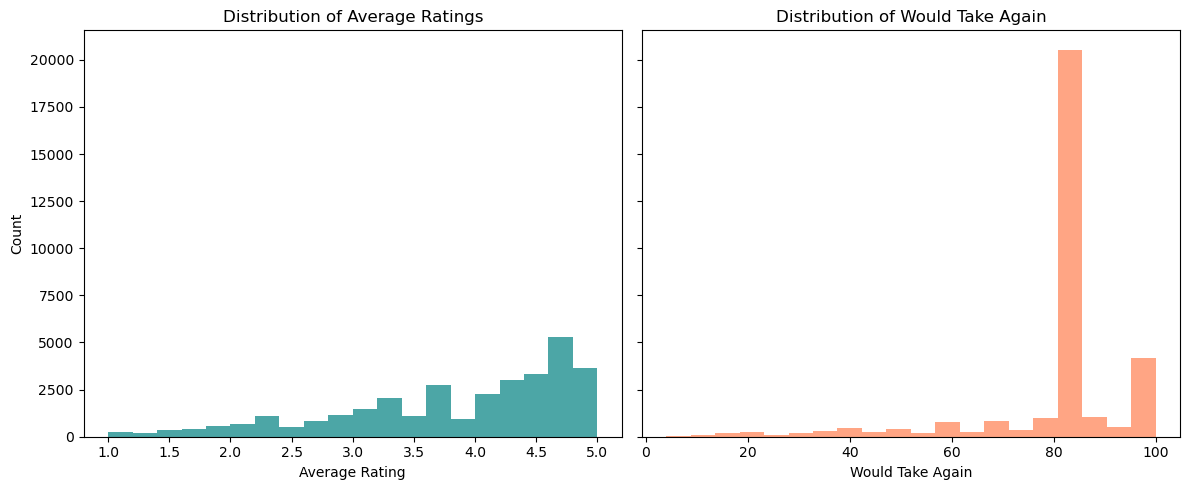

[ 83.  83.  56. ...  83. 100.  83.]


In [2339]:
avg_rating = data_clean[:, 0]
would_take_again = data_clean[:, 4]
# Plot distributions of average rating and would take again side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)             
# Distribution of average rating
axes[0].hist(avg_rating, bins=20, alpha=0.7, color='teal')
axes[0].set_title("Distribution of Average Ratings")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Count")
# Distribution of would take again
axes[1].hist(would_take_again, bins=20, alpha=0.7, color='coral')
axes[1].set_title("Distribution of Would Take Again")
axes[1].set_xlabel("Would Take Again")
plt.tight_layout()
plt.show()

print(would_take_again)

Spearman correlation coefficient: 0.45558826966841004
Pearson correlation coefficient: 0.44747422181113194


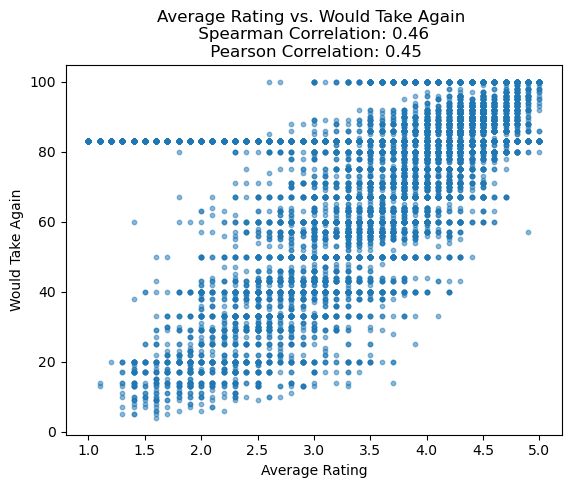

In [2340]:
plt.scatter(avg_rating, would_take_again, alpha=0.5, s=10) # s controls point size, alpha controls transparency
# Add labels and title
spearman_corr, p_val = spearmanr(avg_rating, would_take_again)
pearson_corr = stats.pearsonr(avg_rating, would_take_again)[0]
print("Spearman correlation coefficient:", spearman_corr)
print("Pearson correlation coefficient:", pearson_corr)
plt.ylabel("Would Take Again")
plt.xlabel("Average Rating")
plt.title("Average Rating vs. Would Take Again \n Spearman Correlation: {:.2f} \n Pearson Correlation: {:.2f}".format(spearman_corr, pearson_corr))    

# Show plot
plt.show()

In [2341]:
spearman_corr, p_val = spearmanr(avg_rating, would_take_again)
print("Spearman correlation coefficient:", spearman_corr)


Spearman correlation coefficient: 0.45558826966841004


In [2342]:
pearson_corr, _ = stats.pearsonr(avg_rating, would_take_again)
print("Pearson correlation coefficient:", pearson_corr)

Pearson correlation coefficient: 0.44747422181113194


## Hot vs ratings

In [2343]:
hot_prof = data_clean[:, 3]  # Pepper score
avg_rating = data_clean[:, 0]

In [2344]:
print(avg_rating.shape)
print(hot_prof.shape)

hot_rating = avg_rating[hot_prof == 1]
not_rating = avg_rating[hot_prof == 0]
print(hot_rating)
print(not_rating)

print(hot_rating.shape)
print(not_rating.shape)

(31951,)
(31951,)
[3.6 2.6 4.3 ... 5.  3.9 5. ]
[3.2 3.5 2.6 ... 2.8 3.6 3.6]
(12765,)
(19186,)


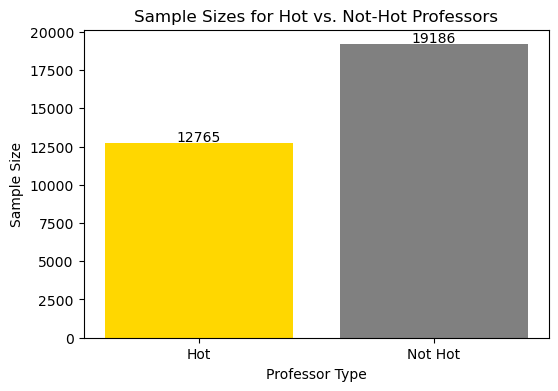

Number of 'Hot' professors: 12765
Number of 'Not Hot' professors: 19186


In [2345]:
# Get sample sizes
n_hot = len(hot_rating)
n_not = len(not_rating)

# Data for plotting
labels = ['Hot', 'Not Hot']
sizes = [n_hot, n_not]

# Create bar plot
plt.figure(figsize=(6, 4)) # Optional: Adjust figure size
plt.bar(labels, sizes, color=['gold', 'gray'])

# Add labels and title
plt.xlabel("Professor Type")
plt.ylabel("Sample Size")
plt.title("Sample Sizes for Hot vs. Not-Hot Professors")

# Add text labels on top of bars
for i, size in enumerate(sizes):
    plt.text(i, size + 100, str(size), ha='center') # Adjust offset as needed

# Show plot
plt.show()

print(f"Number of 'Hot' professors: {n_hot}")
print(f"Number of 'Not Hot' professors: {n_not}")

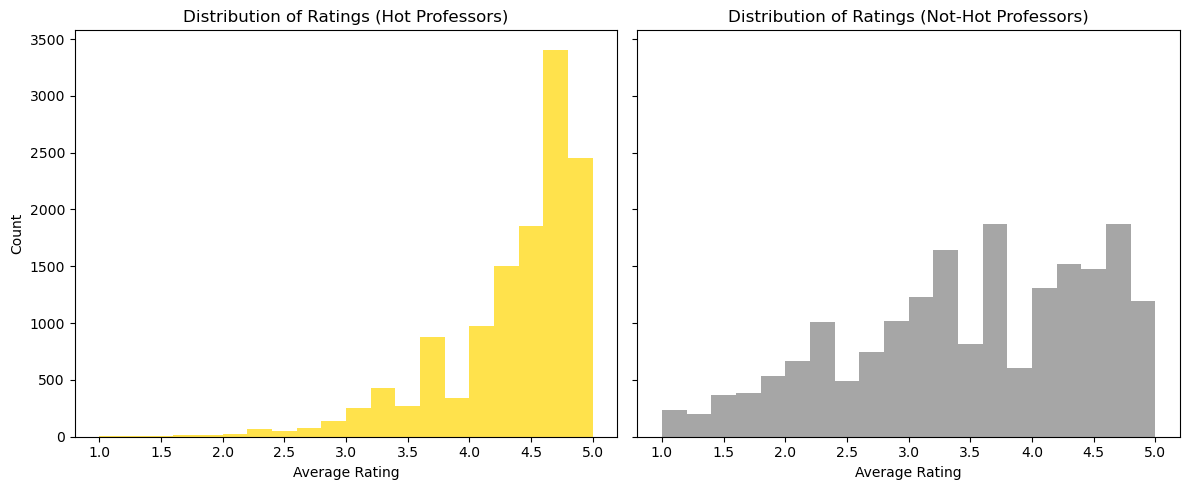

In [2346]:
# Plot distributions of ratings for hot vs. not-hot professors
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Distribution for hot professors
axes[0].hist(hot_rating, bins=20, alpha=0.7, color='gold')
axes[0].set_title("Distribution of Ratings (Hot Professors)")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Count")

# Distribution for not-hot professors
axes[1].hist(not_rating, bins=20, alpha=0.7, color='gray')
axes[1].set_title("Distribution of Ratings (Not-Hot Professors)")
axes[1].set_xlabel("Average Rating")

plt.tight_layout()
plt.show()

significance test

In [2347]:
u_stat, p_val = stats.mannwhitneyu(hot_rating, not_rating)
print("U-statistic:", u_stat)
print("p-value:", p_val)
if p_val < alpha:
    print("Reject null hypothesis: there is a significant difference in ratings")

print(np.median(hot_rating), np.median(not_rating))

U-statistic: 187547087.5
p-value: 0.0
Reject null hypothesis: there is a significant difference in ratings
4.5 3.6


In [2348]:
#ks test
ks_stat, p_val_ks = stats.ks_2samp(hot_rating, not_rating)
print("KS statistic:", ks_stat)
print("KS p-value:", p_val_ks)
if p_val_ks < alpha:
    print("Reject null hypothesis: there is a significant difference in ratings (KS test)")

KS statistic: 0.4149771574610338
KS p-value: 0.0
Reject null hypothesis: there is a significant difference in ratings (KS test)


### Regression : predicting rating from difficulty

In [2349]:
y = data_clean[:, 0]  
X = data_clean[:, 1:] #all predictors except the rating

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (31951, 7)
y shape: (31951,)


In [2350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)    
print("y_test shape:", y_test.shape)

X_train shape: (25560, 7)
y_train shape: (25560,)
X_test shape: (6391, 7)
y_test shape: (6391,)


In [2351]:
difficulty_train = X_train[:, 0].reshape(-1,1)  # Average Difficulty
difficulty_test = X_test[:, 0].reshape(-1,1)  # Average Difficulty

In [2352]:
model = LinearRegression()
model.fit(difficulty_train, y_train)
y_pred = model.predict(difficulty_test)
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 0.7705440436136871
R^2: 0.3810998013075717


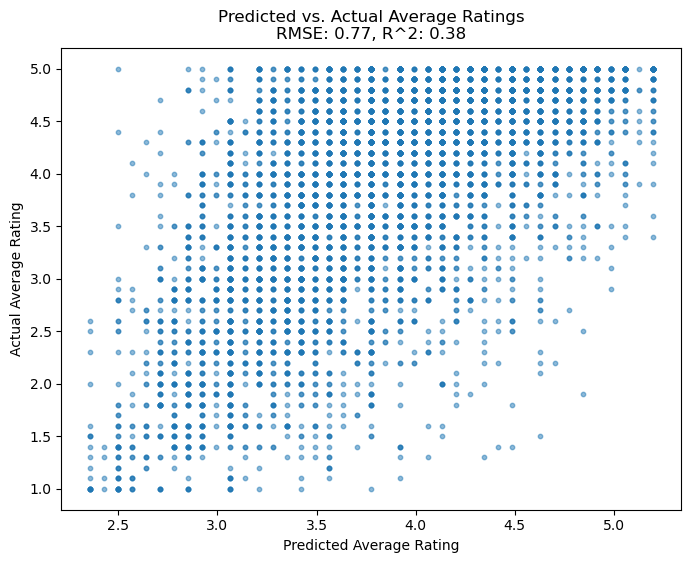

In [2353]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.5, s=10) # s controls point size, alpha controls transparency
# Add labels and title
plt.xlabel("Predicted Average Rating")
plt.ylabel("Actual Average Rating")
plt.title("Predicted vs. Actual Average Ratings\nRMSE: {:.2f}, R^2: {:.2f}".format(rmse, r2))
# Show plot
plt.show()

### Predicting avg rating from all available predictors

In [2354]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 0.6691014943426242
R^2: 0.533330211259659


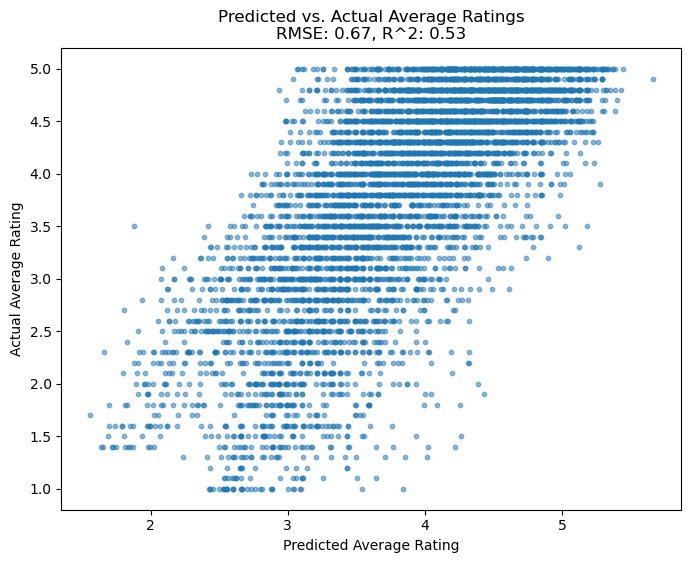

In [2355]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, alpha=0.5, s=10) # s controls point size, alpha controls transparency
# Add labels and title
plt.xlabel("Predicted Average Rating")
plt.ylabel("Actual Average Rating")
plt.title("Predicted vs. Actual Average Ratings\nRMSE: {:.2f}, R^2: {:.2f}".format(rmse, r2))
# Show plot
plt.show()

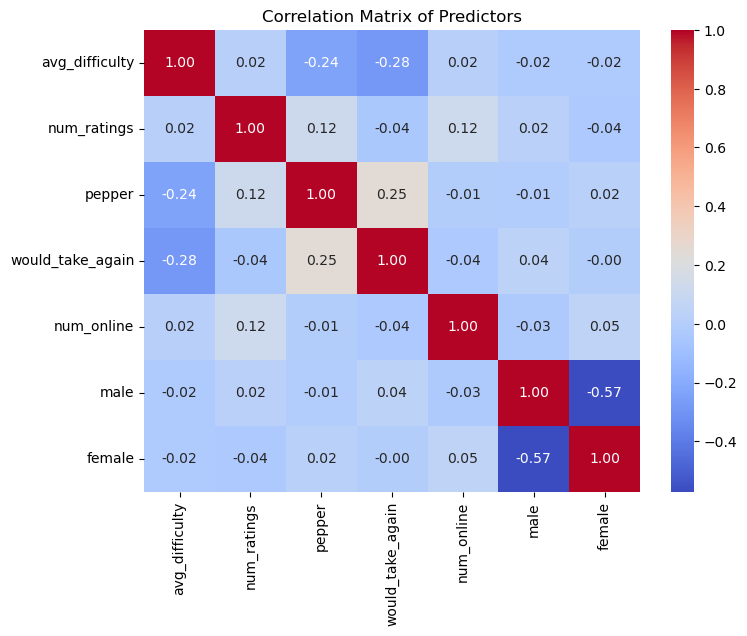

In [2356]:
import seaborn as sns

predictors = ["avg_difficulty", "num_ratings", "pepper", "would_take_again", "num_online", "male", "female"]

corr_matrix = np.corrcoef(X.T)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=predictors, yticklabels=predictors)
plt.title("Correlation Matrix of Predictors")
plt.show()

In [2357]:
all_pred_wo_female_train = X_train[:, [0, 1, 2, 3, 4, 5]] 
all_pred_wo_female_test = X_test[:, [0, 1, 2, 3, 4, 5]]

model = LinearRegression()
model.fit(all_pred_wo_female_train, y_train)
y_pred = model.predict(all_pred_wo_female_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 0.6694271098937215
R^2: 0.5328758947894178


### Classification: Predicting "pepper"

In [2358]:
y = data_clean[:, 3]
X = np.hstack((data_clean[:, :3], data_clean[:, 4:]))  # all predictors except the hot professor indicator

print("X shape:", X.shape)
print("y shape:", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X shape: (31951, 7)
y shape: (31951,)
X_train shape: (25560, 7)
y_train shape: (25560,)
X_test shape: (6391, 7)
y_test shape: (6391,)


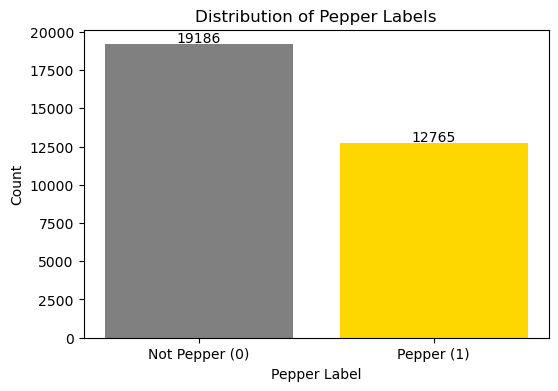

In [2359]:
# Calculate counts of 0s and 1s in y
unique_labels, counts = np.unique(y, return_counts=True)

# Data for plotting
labels = ['Not Pepper (0)', 'Pepper (1)'] # Assuming 0 means not pepper, 1 means pepper
sizes = counts

# Create bar plot
plt.figure(figsize=(6, 4)) # Optional: Adjust figure size
plt.bar(labels, sizes, color=['gray', 'gold'])

# Add labels and title
plt.xlabel("Pepper Label")
plt.ylabel("Count")
plt.title("Distribution of Pepper Labels")

# Add text labels on top of bars
for i, size in enumerate(sizes):
    plt.text(i, size + 100, str(size), ha='center') # Adjust offset as needed

# Show plot
plt.show()

In [2360]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [2361]:
avg_rating_train = X_train[:, 0].reshape(-1,1)  # Average Difficulty
avg_rating_test = X_test[:, 0].reshape(-1,1)  # Average Difficulty

In [2362]:
model = LogisticRegression()
model.fit(avg_rating_train, y_train)
y_pred = model.predict(avg_rating_test)

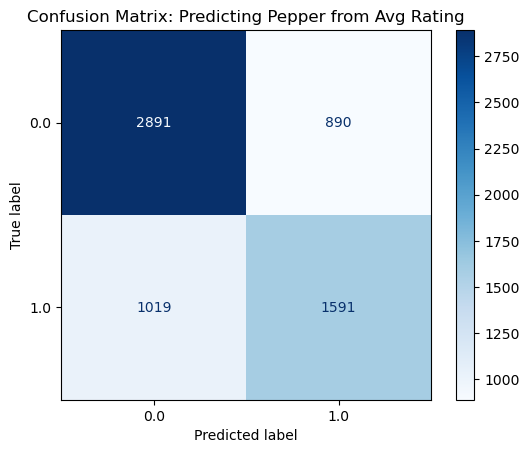

Accuracy: 0.7012987012987013


In [2363]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Predicting Pepper from Avg Rating")
plt.show()

# Print accuracy score (optional, but often useful with confusion matrix)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

AUC: 0.7660904340212861


Text(0.5, 1.0, 'ROC Curve')

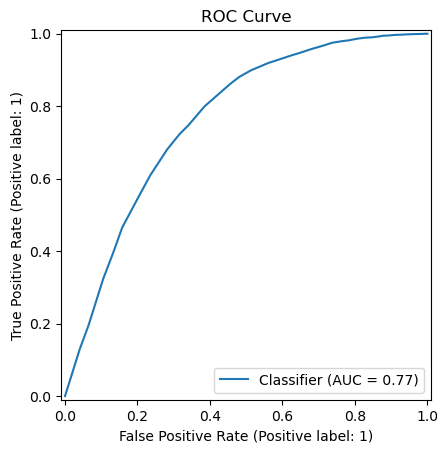

In [2364]:
y_pred_proba = model.predict_proba(avg_rating_test)[:, 1]  # Probability estimates for the positive class
print("AUC:", roc_auc_score(y_test, y_pred_proba))

metrics.RocCurveDisplay.from_predictions(y_test, y_pred_proba, pos_label=1)
plt.title('ROC Curve')

### predicting "pepper" from all features

In [2365]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [2366]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7130339539978094


AUC: 0.7816113234046823


Text(0.5, 1.0, 'ROC Curve')

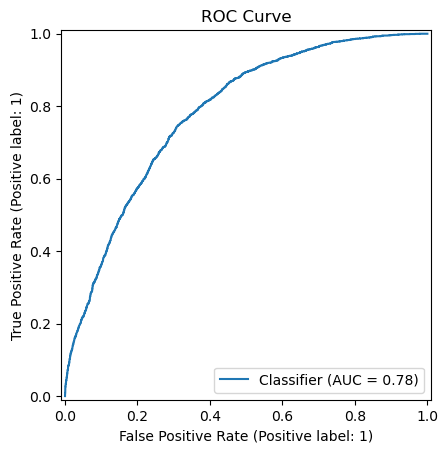

In [2367]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
print("AUC:", roc_auc_score(y_test, y_pred_proba))

metrics.RocCurveDisplay.from_predictions(y_test, y_pred_proba, pos_label=1)
plt.title('ROC Curve')

### Extra credit


combine qual data

In [2368]:
comb_clean = np.column_stack((avg_rating_clean, avg_difficulty_clean, num_ratings_clean,
                             pepper_clean, would_take_again_clean,
                             online_class_clean, male_clean, female_clean, rmp_qual_np))
comb_clean = comb_clean[num_ratings_clean >= 4]
print(would_take_again_clean)
comb_clean

[ 83.  83.  83. ... 100.  83.  83.]


array([[3.2, 3.0, 4.0, ..., 'English', 'Alabama State University', 'AL'],
       [3.6, 3.5, 10.0, ..., 'English', 'University of Kentucky', 'KY'],
       [3.5, 3.3, 22.0, ..., 'English', 'Eastern Florida State College',
        'FL'],
       ...,
       [3.9, 3.8, 4.0, ..., 'Psychology', 'University of Ottawa', 'ON'],
       [5.0, 1.7, 6.0, ..., 'Criminal Justice',
        'Salt Lake Community College', 'UT'],
       [3.6, 1.8, 5.0, ..., 'French', 'University of Ottawa', 'ON']],
      dtype=object)

In [ ]:
majors = comb_clean[:, -3]

is_stem = np.array([1 if isinstance(major, str) and major in stem_majors else 0 for major in majors])

# Add the new column to comb_clean
comb_clean = np.column_stack((comb_clean, is_stem))

# Verify the shape and the new column
print("Shape after adding STEM column:", comb_clean.shape)
print("Sample of STEM column:", is_stem[:20]) # Print first 20 entries of the new column
print("Number of STEM majors identified:", np.sum(is_stem))

comb_clean

Shape after adding STEM column: (31951, 12)
Sample of STEM column: [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0]
Number of STEM majors identified: 9963


array([[3.2, 3.0, 4.0, ..., 'Alabama State University', 'AL', 0],
       [3.6, 3.5, 10.0, ..., 'University of Kentucky', 'KY', 0],
       [3.5, 3.3, 22.0, ..., 'Eastern Florida State College', 'FL', 0],
       ...,
       [3.9, 3.8, 4.0, ..., 'University of Ottawa', 'ON', 0],
       [5.0, 1.7, 6.0, ..., 'Salt Lake Community College', 'UT', 0],
       [3.6, 1.8, 5.0, ..., 'University of Ottawa', 'ON', 0]],
      dtype=object)

In [2380]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X = data_clean[:, :8]  # Use only the numerical features for clustering

In [2381]:
# X = stats.zscore(X, axis=0)  # Standardize the data
silhouette_scores = []
for k in range(2, 20):
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=rand)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_score_value = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_score_value)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Optimal number of clusters (k):  2


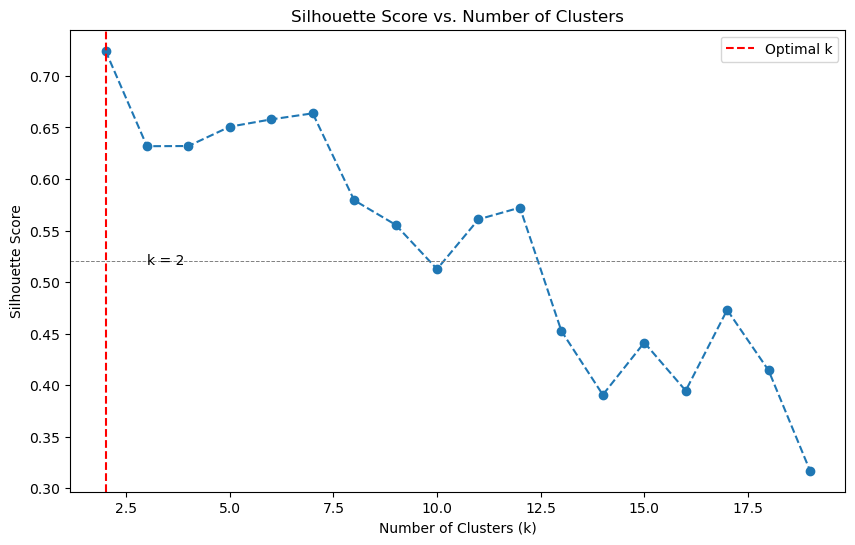

In [2382]:
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Optimal number of clusters (k): ", optimal_k)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal k')
# Add text annotation indicating the optimal k value near the line
# Position the text slightly to the right of the line and vertically centered
y_range = plt.ylim()
text_y_pos = y_range[0] + (y_range[1] - y_range[0]) * 0.5 # Calculate mid y-position
plt.text(optimal_k + 1, text_y_pos, f'k = {optimal_k}', color='black', verticalalignment='center')
plt.axhline(y=text_y_pos, color='gray', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()

In [2383]:
kmeans = KMeans(n_clusters=optimal_k, random_state=rand)
kmeans.fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

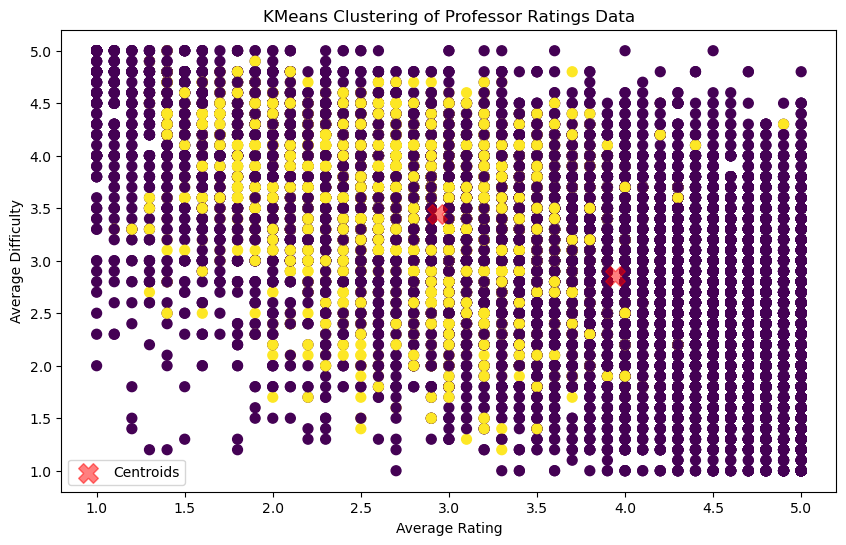

In [2384]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50) 
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X', label='Centroids')
plt.xlabel("Average Rating")
plt.ylabel("Average Difficulty")
plt.title('KMeans Clustering of Professor Ratings Data')
plt.legend()
plt.show()

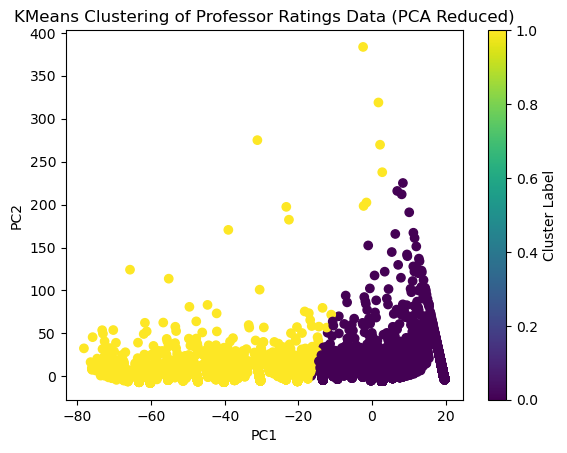

[[ 2.76192430e+00 -5.56094844e+00 -3.80480280e-01 ... -4.79746248e-01
  -1.07583290e-01  1.83473819e-01]
 [ 2.47604168e+00  4.38724127e-01 -4.78781568e-01 ...  4.98100503e-01
   5.61543773e-01 -4.78553809e-01]
 [-2.51010525e+01  1.12080270e+01  6.20430596e+00 ...  1.98651614e-02
  -3.10482192e-01  1.34642274e-01]
 ...
 [ 2.77570021e+00 -5.55220486e+00 -3.60271792e-01 ...  1.00162824e+00
   3.43609205e-01  2.26355772e-01]
 [ 1.97026834e+01 -2.67341761e+00  1.58234481e+00 ... -2.36017454e-01
   3.84259936e-01  1.49974994e-01]
 [ 2.74033363e+00 -4.55982983e+00 -4.06212030e-01 ... -1.10586047e+00
  -5.75039588e-02 -5.11747815e-01]]


In [2385]:
pca = PCA(); coords = pca.fit_transform(X)
plt.scatter(coords[:,0], coords[:,1], c=kmeans.labels_)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('KMeans Clustering of Professor Ratings Data (PCA Reduced)')
plt.colorbar(label='Cluster Label')
plt.show()
print(coords)

In [2387]:
temp = comb_clean[:, -1]

# Filter temp (state data) based on cluster labels
mask_label_0 = (labels == 0)
mask_label_1 = (labels == 1)

temp_label_0 = temp[mask_label_0]
temp_label_1 = temp[mask_label_1]

# Create DataFrame with states for each label. Use pd.Series to handle potential length differences.
df_states_by_label = pd.DataFrame({
    'Label 0': pd.Series(temp_label_0),
    'Label 1': pd.Series(temp_label_1)
})

print(df_states_by_label.head())

print(df_states_by_label.count())

sample1 = df_states_by_label['Label 0'].dropna()
sample2 = df_states_by_label['Label 1'].dropna()



  Label 0 Label 1
0       0       0
1       0       0
2       0       0
3       0       0
4       0       0
Label 0    28452
Label 1     3499
dtype: int64
